In [535]:
import qiskit
from qiskit.quantum_info import state_fidelity
import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt


# Parameters for the Ising Hamiltonian
# L has to be even! Due to K only being able to control even Ls!
L = 6

# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
#hamil = qib.IsingHamiltonian(field, 1, 0, 0).as_matrix().toarray()
hamil = qib.HeisenbergHamiltonian(field, (1,1,1), (0,0,0)).as_matrix().toarray()
perms = [[i for i in range(L)], [i for i in range(1, L)]+[0]]
#perms = [[0, 1]]

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", -eigenvalues_sort[-1].real)

Ground State Energy -6.000000000000011


In [536]:
def unitary_approximation(V):
    U, _, Vh = np.linalg.svd(V)
    unitary_approx = U @ Vh
    return unitary_approx

In [537]:
import scipy

U = scipy.linalg.expm(-1j*hamil)
U_back = scipy.linalg.expm(1j*hamil)
cU = U_back

In [538]:
I2 = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

In [539]:
import sys
sys.path.append("../ccU")
from utils import otimes, applyG
from ansatz import ansatz, ansatz_grad_vector
from hessian import ansatz_hessian_matrix

V1 = np.kron(X, I2)
V2 = np.kron(I2, I2)
W1 = V1
W2 = V2
Glist_opt = [V1, V2, W1, W2]
#Glist_opt = [V1, W1]

np.linalg.norm(cU - ansatz(Glist_opt, U, L, perms), ord=2)

1.9643062100000424

In [540]:
from optimize import err

err(Glist_opt, U, L, perms, cU)

5.112942805383254

In [541]:
grad = ansatz_grad_vector(Glist_opt, cU, U, L, perms, flatten=True)
np.linalg.norm(grad, ord=2)

# Gradient is indeed 0 at the optimal/exact solution. -> Suggested me that my gradient is correct (?)

23.28420348821157

In [542]:
# Random unitary generator
def random_unitary(n):
    A = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    Q, _ = np.linalg.qr(A)
    return Q

In [543]:
# Initial params.
Glist = [random_unitary(4) for i in range(len(2*perms))]

np.linalg.norm(cU - ansatz(Glist, U, L, perms), ord=2)

1.9998900783219251

In [548]:
import numpy as np
from utils import antisymm_to_real, antisymm, partial_trace_keep

f = err

# Function to compute analytical gradient
def grad_analytical(Glist, U, cU, L, perms, flatten=True):
    return -ansatz_grad_vector(Glist, cU, U, L, perms, flatten=flatten)


def grad_numerical(Glist, U, cU, epsilon=1e-6, flatten=True):
    grads = []
    for _ in range(len(Glist)):
        W = Glist[_]
        d = Glist[_].shape[0]
        grad_complex = np.zeros((d, d), dtype=complex)

        for i in range(d):
            for j in range(d):
                # Real perturbation
                dW_real = np.zeros_like(W, dtype=complex)
                dW_real[i, j] = epsilon

                Glist_plus_real  = Glist[:_] + [W + dW_real] + Glist[_+1:]
                Glist_minus_real = Glist[:_] + [W - dW_real] + Glist[_+1:]
                
                f_plus  = f(Glist_plus_real, U, L, perms, cU)
                f_minus = f(Glist_minus_real, U, L, perms, cU)
                df_real = (f_plus - f_minus) / (2 * epsilon)

                # Imaginary perturbation
                dW_imag = np.zeros_like(W, dtype=complex)
                dW_imag[i, j] = 1j * epsilon

                Glist_plus_imag  = Glist[:_] + [W + dW_imag] + Glist[_+1:]
                Glist_minus_imag = Glist[:_] + [W - dW_imag] + Glist[_+1:]
                
                f_plus  = f(Glist_plus_imag, U, L, perms, cU)
                f_minus = f(Glist_minus_imag, U, L, perms, cU)
                df_imag = (f_plus - f_minus) / (2 * epsilon)
    
                grad_complex[i, j] = df_real + 1j * df_imag
        grads.append(grad_complex)
    
    stack = np.stack([ antisymm_to_real(antisymm(W.conj().T @ grads[j])) for j, W in enumerate(Glist)])
    if flatten:
        return stack.reshape(-1)
    return stack

# Compute gradients
grad_a = grad_analytical(Glist, U, cU, L, perms, flatten=True)
grad_n = grad_numerical(Glist, U, cU, flatten=True)

# Compare
error = np.linalg.norm(grad_a - grad_n)
print("Difference (Frobenius norm):", error)

Difference (Frobenius norm): 6.690912885020449e-09


In [549]:
#Glist_pert = [perturb_unitary(G, epsilon=1) for G in Glist_opt]
V1 = np.kron(Z, I2)
V2 = np.kron(I2, I2)
W1 = V1
W2 = V2
Glist_pert = [V1, V2, W1, W2]

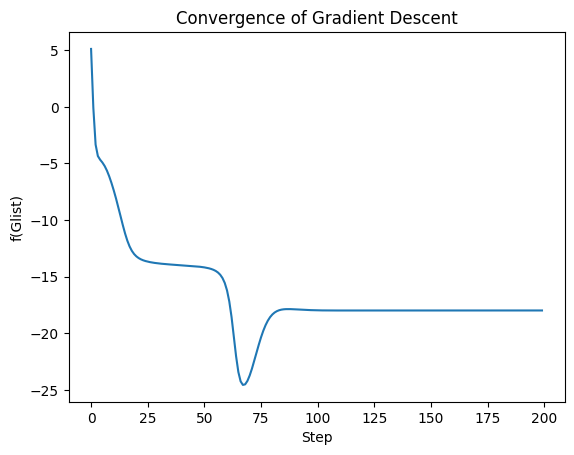

In [550]:
"""
    Perturb the optimal Glist slightly and apply gradient descent to see if 
    the gradient is behaving correctly. This indeed seems to be the case.
"""

def perturb_unitary(G, epsilon=1e-2):
    A = np.random.randn(*G.shape) + 1j * np.random.randn(*G.shape)
    H = 0.5 * (A + A.conj().T)  # Hermitian
    return scipy.linalg.expm(-1j * epsilon * H) @ G

def step_Glist(Glist, grad, lr):
    Glist_new = []
    for G, g in zip(Glist, grad):
        # Recover anti-Hermitian A from real-valued g
        A = 0.5 * (g - g.T) + 0.5j * (g + g.T)  # this is anti-Hermitian: A† = -A
        # Riemannian update on unitary manifold:
        G_new = scipy.linalg.expm(-lr * A) @ G  # guarantees G_new is unitary
        Glist_new.append(G_new)
    return Glist_new


Glist = Glist_pert
history = []
for step in range(200):
    loss = f(Glist, U, L, perms, cU)
    history.append(loss)
    grad = grad_analytical(Glist, U, cU, L, perms, flatten=False)
    Glist = step_Glist(Glist, grad, lr=0.01)
    #print(f"Step {step}, f = {loss:.6f}")

    if np.abs(loss + 16) < 1e-3:  # convergence criterion for L=4 (Tr(I) = 16)
        print("Converged!")
        break

import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel("Step")
plt.ylabel("f(Glist)")
plt.title("Convergence of Gradient Descent")
plt.show()

In [551]:
"""
    We see that a global optimum is achivable in L=2 case just by gradient descent.
"""

Glist_opt_L2 = Glist
np.linalg.norm(ansatz(Glist_opt_L2, U, L, perms) - cU, ord=2)

1.9565538827014992

In [552]:
L = 4

# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
#hamil = qib.IsingHamiltonian(field, 1, 0, 0).as_matrix().toarray()
hamil = qib.HeisenbergHamiltonian(field, (1,1,1), (0,0,0)).as_matrix().toarray()
perms = [[i for i in range(L)], [i for i in range(1, L)]+[0]]
U = scipy.linalg.expm(-1j*hamil)
U_back = scipy.linalg.expm(1j*hamil)
cU = U_back

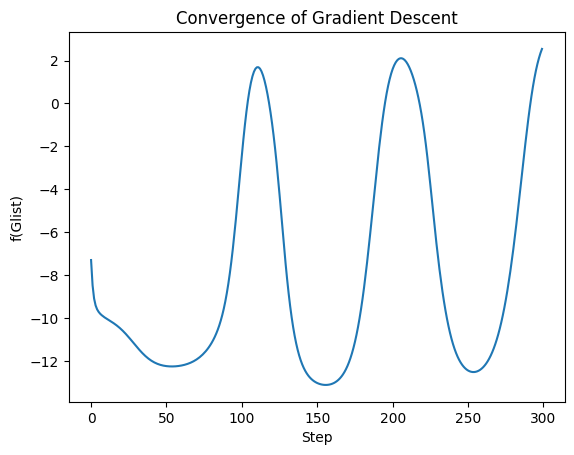

In [553]:

#Glist = [random_unitary(4) for i in range(len(Glist))]
Glist = Glist_opt_L2

history = []
for step in range(300):
    loss = f(Glist, U, L, perms, cU)
    history.append(loss)
    grad = grad_analytical(Glist, U, cU, L, perms, flatten=False)
    Glist = step_Glist(Glist, grad, lr=0.01)
    #print(f"Step {step}, f = {loss:.6f}")
    
    if np.abs(loss + 16) < 1:  # convergence criterion for L=4 (Tr(I) = 16)
        print("Converged!")
        break
    
import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel("Step")
plt.ylabel("f(Glist)")
plt.title("Convergence of Gradient Descent")
plt.show()

In [554]:
"""
    In L=4 case we achieve only a local minimum with the gradient descent.
    More important question: Is there a global minimum that's smaller than
    f = -13? Can Riemannian Trust Region enable us this?
"""

Glist_opt_L4 = Glist
np.linalg.norm(ansatz(Glist, U, L, perms) - cU, ord=2)

1.96593918237747

In [555]:
"""
    Also, resuing the optimal gates of L=2 doesnt really bring us anything.
    Important Question: Optimizing for small system and scaling to larger 
    system will fail?
"""

L = 6
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
#hamil = qib.IsingHamiltonian(field, 1, 0, 0).as_matrix().toarray()
hamil = qib.HeisenbergHamiltonian(field, (1,1,1), (0,0,0)).as_matrix().toarray()
perms = [[i for i in range(L)], [i for i in range(1, L)]+[0]]
U = scipy.linalg.expm(-1j*hamil)
U_back = scipy.linalg.expm(1j*hamil)
cU = U_back
print("Reusing L=2 gates for L=6: ", np.linalg.norm(ansatz(Glist_opt_L2, U, L, perms) - cU, ord=2))

Reusing L=2 gates for L=6:  1.9565538827014992


In [ ]:
from utils import antisymm, antisymm_to_real, applyG_block

def ansatz_grad_vector_LOCAL(Glist, cU, U, L, perms, flatten=True):
    Vs = Glist[:len(perms)]
    Ws = Glist[len(perms):]
    W = Ws[1]
    
    U_tilde = applyG_block(Ws[0], L, perms[0]) @ U @ applyG_block(Vs[1], L, perms[1]) @ applyG_block(Vs[0], L, perms[0]) @ cU.conj().T
    grad = ansatz_grad(W2, L, U_tilde, perms[1])
    grad = grad.conj().T

    return antisymm_to_real(
        W @  # THIS IS THE FIX??!?!?!
        antisymm(W.conj().T @ grad) ) 
    #return grad

In [ ]:
from utils import antisymm, antisymm_to_real

def ansatz_grad_vector_LOCAL(Glist, cU, U, L, perms, flatten=True):
    V = Glist[:len(perms)][0]
    W = Glist[len(perms):][0]
    
    grads_V = [] 
    U_tilde = cU.conj().T
    U_tilde = U_tilde @ W
    U_tilde = U_tilde @ U
    grads_V.append(U_tilde)

    grads_W = []
    U_tilde = U.conj().T @ V.conj().T @ cU
    grads_W.append(U_tilde)
    grad = np.stack(grads_V + grads_W)

    return np.stack([antisymm_to_real( 
        Glist[j] @  # THIS IS THE FIX??!?!?!
        antisymm(Glist[j].conj().T @ grad[j]) ) for j in range(len(grad))])